# Neural Color Transfer (Multi-Reference Style Transfer)

### Library

In [1]:
#Append 'src' direc to import modules from notebooks directory#
##################################################
#import os,sys
#src_dir=os.path.join(os.getcwd(),os.pardir)
#sys.path.append(src_dir)
#################################################

In [2]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import matplotlib as plt
import time
import os
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import cv2
from torchvision import transforms
from torchvision.utils import make_grid
from collections import OrderedDict
from PIL import Image,ImageOps
import torch.optim as optim
import scipy

### Input Source & Reference Image

In [4]:
imgS_path = '../image/city_basic.jpg'
imgR_path='../image/city_night.jpg'
imgS=imread('image/city_basic.jpg')
imgR=imread('image/city_night.jpg')

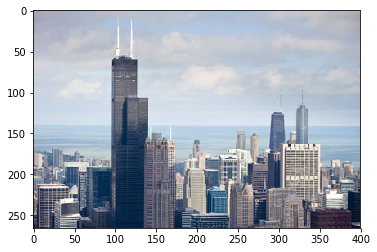

In [5]:
imshow(imgS)

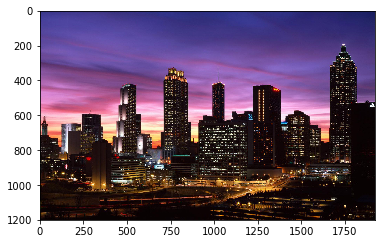

In [6]:
imshow(imgR)

In [66]:
#imgST = torchvision.transforms.ToTensor()
imgST = torch.from_numpy(np.flip(imgS.transpose((2, 0, 1)),axis=0).copy()).unsqueeze(0)
print(imgST)
#imgRT = torchvision.transforms.ToTensor()
imgRT = torch.from_numpy(np.flip(imgR.transpose((2, 0, 1)),axis=0).copy()).unsqueeze(0)
print(imgRT)

tensor([[[[ 179,  179,  179,  ...,  181,  181,  180],
          [ 178,  178,  178,  ...,  179,  178,  178],
          [ 178,  178,  178,  ...,  178,  178,  177],
          ...,
          [  66,   70,   83,  ...,   41,   70,   90],
          [  75,   69,   69,  ...,   29,   28,   28],
          [  71,   67,   63,  ...,   33,   33,   33]],

         [[ 165,  165,  165,  ...,  174,  174,  173],
          [ 164,  164,  164,  ...,  172,  171,  171],
          [ 164,  164,  164,  ...,  168,  168,  167],
          ...,
          [  50,   51,   64,  ...,   43,   74,   95],
          [  41,   43,   42,  ...,   11,   10,   10],
          [  37,   41,   36,  ...,   15,   15,   15]],

         [[ 166,  166,  166,  ...,  179,  179,  178],
          [ 165,  165,  165,  ...,  177,  176,  176],
          [ 165,  165,  165,  ...,  174,  174,  173],
          ...,
          [  44,   43,   59,  ...,   43,   75,   98],
          [  28,   27,   32,  ...,    0,    0,    0],
          [  24,   25,   26,  ...

### Process
From S_6 = S_L+1 to S_1(Final Result)

S,R
-> Feature Domain [(from VGG 19 extract feature map = Fs Fr) -> NNF Search -> Mapping Function(optimize by PatchMatch alg.)
->Image Domain[(with S down sample, BDS voted Guidance) -> Local Color Transfer -> ]

### FeatureExtractor

In [8]:
model1 = models.vgg19(pretrained=True).features
print(model1)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [9]:
relu_1 = model1[1] #1,6,11,20,29
relu_2 = model1[6]
relu_3 = model1[11]
relu_4 = model1[20]
relu_5 = model1[29]

print(relu_1)
print(relu_2)

ReLU(inplace)
ReLU(inplace)


tensor([[[ 179.,  179.,  179.,  ...,  181.,  181.,  180.],
         [ 178.,  178.,  178.,  ...,  179.,  178.,  178.],
         [ 178.,  178.,  178.,  ...,  178.,  178.,  177.],
         ...,
         [  66.,   70.,   83.,  ...,   41.,   70.,   90.],
         [  75.,   69.,   69.,  ...,   29.,   28.,   28.],
         [  71.,   67.,   63.,  ...,   33.,   33.,   33.]],

        [[ 165.,  165.,  165.,  ...,  174.,  174.,  173.],
         [ 164.,  164.,  164.,  ...,  172.,  171.,  171.],
         [ 164.,  164.,  164.,  ...,  168.,  168.,  167.],
         ...,
         [  50.,   51.,   64.,  ...,   43.,   74.,   95.],
         [  41.,   43.,   42.,  ...,   11.,   10.,   10.],
         [  37.,   41.,   36.,  ...,   15.,   15.,   15.]],

        [[ 166.,  166.,  166.,  ...,  179.,  179.,  178.],
         [ 165.,  165.,  165.,  ...,  177.,  176.,  176.],
         [ 165.,  165.,  165.,  ...,  174.,  174.,  173.],
         ...,
         [  44.,   43.,   59.,  ...,   43.,   75.,   98.],
         [

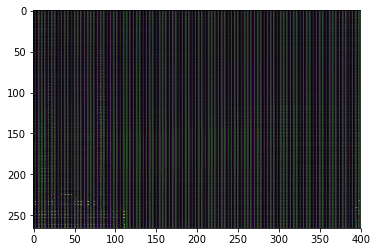

In [64]:
reS = relu_1(Variable(imgST.float(),requires_grad=False)).squeeze(0)
#print(reS)
#print(reS.size)
reSnp = reS.numpy()
reSnp = reSnp.transpose(1,2,0)
#print(reSnp)
reSnpImg = Image.fromarray(reSnp,'RGB') 
reSnpImg.save('processImage/reSnpImg.jpg')
reSnpImg = imread('processImage/reSnpImg.jpg')
imshow(reSnpImg)

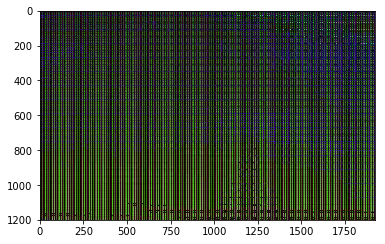

In [68]:
reR = relu_1(Variable(imgRT.float(),requires_grad=False)).squeeze(0)
reRnp = reR.numpy()
reRnp = reRnp.transpose(1,2,0)
reRnpImg = Image.fromarray(reRnp,'RGB') 
reRnpImg.save('processImage/reRnpImg.jpg')
reRnpImg = imread('processImage/reRnpImg.jpg')
imshow(reRnpImg)